In [1]:
# ref: https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn/
# https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

import torch as T
import torchvision as TV
from torchvision.utils import make_grid
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
from glob import glob 
from tqdm.notebook import tqdm
from PIL import Image
import random

In [36]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

coco_names = class_names
print(len(coco_names))

81


In [14]:
# randomly generate the RGB map for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [15]:
def get_output(img, model, threshold):
    with T.no_grad():
        outputs = model(img)
        
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    masks = masks[:thresholded_preds_count]
    
    boxes = [[
                (int(i[0]), int(i[1])),
                (int(i[2]), int(i[3]))
    ] for i in outputs[0]['boxes'].detach().cpu().numpy()]
    boxes = boxes[:thresholded_preds_count]
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return image

In [16]:
print('mps for Mac backend built:', T.backends.mps.is_built())
print('mps available:', T.backends.mps.is_available())
print('cuda available:', T.cuda.is_available())
if T.backends.mps.is_built() and T.backends.mps.is_available():
    # apple device
    device = T.device("mps")
elif  T.cuda.is_available():
    device = T.device("cuda:0") 
else:
    device = 'cpu'

device = 'cpu'  # force the model run on cpu since torch not support topk>16 on M1 Pro
print('Device in use:', device)

mps for Mac backend built: True
mps available: True
cuda available: False
Device in use: cpu


In [37]:
# initialize the model
model = TV.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
model.to(device).eval()

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [38]:
# define the transform methods to be passed to above dataset
myTransformImage = transform.Compose(
    [
        transform.ToTensor(), # needed for almost every CV tasks because the images are stored as np.array at first, we need them to be torch.Tensor
        # transform.RandomHorizontalFlip(p=0.9)
    ]
)

myTransformLabel = transform.Compose(
    [
        transform.ToTensor()
    ]
)

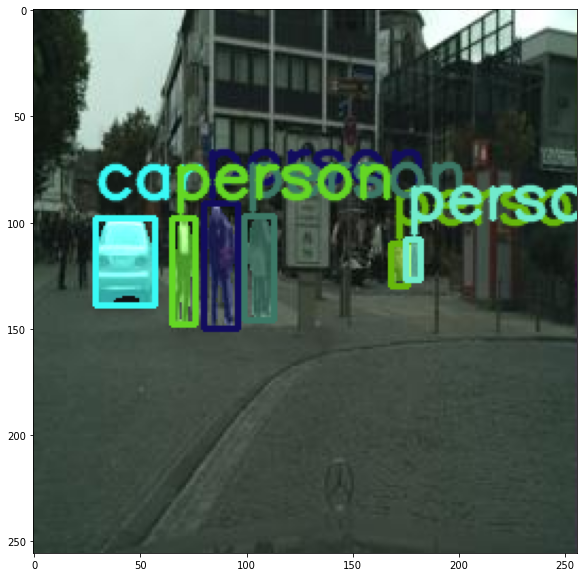

In [46]:
k = 20
threshold = 0.5
image_path = os.path.join(f'./cityscapes_data/train/{k}.jpg')
# image_path = os.path.join('people_test.jpeg')
image = plt.imread(image_path)
image = image[:, :256]
# keep a copy of the original image for OpenCV functions and applying masks
orig_image = image.copy()
# transform the image
image = myTransformImage(image)
# add a batch dimension
image = image.unsqueeze(0).to(device)
masks, boxes, labels = get_output(image, model, threshold)
result = draw_segmentation_map(orig_image, masks, boxes, labels)


# visualize the image
fig, ax = plt.subplots(1,1,figsize=(10, 10))
ax.imshow(result)